# How Depth and Width Affect Multilayer Perceptron Performance on a Medical Diagnosis Task

In this notebook, we study how the **depth** (number of hidden layers) and **width** (number of neurons per layer)
of a **Multilayer Perceptron (MLP)** affect performance on a medical diagnosis task.

We use the **Breast Cancer Wisconsin (Diagnostic)** dataset and build several MLP architectures to compare their
training, validation, and test performance.

> **Note:** This notebook is designed as part of a machine-learning tutorial assignment. You can adapt the text
> and results into your written tutorial, web page, or video script.


In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

# Make sure plots appear inline (for Jupyter)
%matplotlib inline

## 1. Loading the Breast Cancer Wisconsin (Diagnostic) Dataset

We use a CSV version of the Breast Cancer Wisconsin (Diagnostic) dataset. The file is publicly available and can be
loaded directly from a URL.

The **target label** is:

- `diagnosis` — coded as:
  - `M` = malignant
  - `B` = benign

Each row corresponds to one tumour sample, and the remaining columns are numeric features describing characteristics
of cell nuclei (e.g. radius, texture, smoothness, etc.).

In [2]:
# URL to the CSV file (Breast Cancer Wisconsin Diagnostic dataset)
url = "https://raw.githubusercontent.com/plotly/datasets/master/data.csv"

# Load into a pandas DataFrame
df = pd.read_csv(url)

# Quick inspection
print("Shape of raw dataframe:", df.shape)
print("Columns:", df.columns.tolist()[:10], "...")
df.head()

Shape of raw dataframe: (150000, 11)
Columns: ['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse'] ...


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## 2. Basic Cleaning and Target Encoding

We remove non-feature columns (such as `id`) and any completely empty columns. Then we encode the `diagnosis` label:

- Benign (`B`) → 0
- Malignant (`M`) → 1

In [5]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="diagnosis_encoded")

df = X.copy()
df["diagnosis_encoded"] = y

df.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis_encoded
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## 3. Feature/Target Split and Exploratory Analysis

We separate the features from the target variable and perform some basic exploratory analysis, such as:

- Class balance (how many benign vs malignant cases)
- Basic summary statistics

Feature matrix shape: (569, 30)
Target vector shape: (569,)

Class distribution (0=malignant, 1=benign):
diagnosis_encoded
0    212
1    357
Name: count, dtype: int64


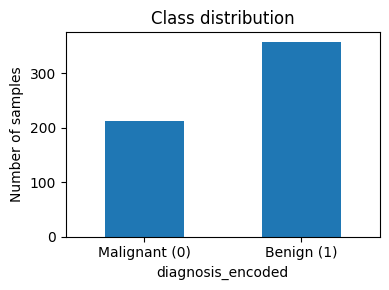

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.98100,11.70000,13.37000,15.7800,28.1100
mean texture,569.0,19.289649,4.301036,9.71000,16.17000,18.84000,21.8000,39.2800
mean perimeter,569.0,91.969033,24.298981,43.79000,75.17000,86.24000,104.1000,188.5000
mean area,569.0,654.889104,351.914129,143.50000,420.30000,551.10000,782.7000,2501.0000
mean smoothness,569.0,0.096360,0.014064,0.05263,0.08637,0.09587,0.1053,0.1634


In [8]:
# Separate features (X) and target (y)
X = df.drop(columns=["diagnosis_encoded"])
y = df["diagnosis_encoded"]

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# Class distribution
class_counts = y.value_counts().sort_index()
print("\nClass distribution (0=malignant, 1=benign):")
print(class_counts)

# Simple bar plot for class distribution
plt.figure(figsize=(4, 3))
class_counts.plot(kind="bar")
plt.xticks([0, 1], ["Malignant (0)", "Benign (1)"], rotation=0)
plt.ylabel("Number of samples")
plt.title("Class distribution")
plt.tight_layout()
plt.show()

# Summary statistics for the first few features
X.describe().T.head()


## 4. Train / Validation / Test Split

To evaluate different network architectures fairly, we split the data into three parts:

- Training set (60%) — used to fit model parameters.
- Validation set (20%) — used for model/architecture selection.
- Test set (20%) — held out until the very end for final evaluation.

We use **stratified splits** so that the class proportions are similar in each subset.

In [9]:
# First split: train+val vs test
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

# Second split: train vs validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of total
    random_state=42,
    stratify=y_temp,
)

print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])

Train size: 341
Validation size: 114
Test size: 114


## 5. Feature Scaling (Standardisation)

MLPs are sensitive to the scale of the input features. We use `StandardScaler` to transform each feature
to have approximately zero mean and unit variance, **fitted on the training data only**, then applied to
validation and test sets using the same transformation.

In [10]:
scaler = StandardScaler()

# Fit on the training data only
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to validation and test sets
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Scaled training feature shape:", X_train_scaled.shape)

Scaled training feature shape: (341, 30)


## 6. Defining a Helper Function to Train and Evaluate MLPs

To systematically compare different architectures, we define a helper function that:

1. Builds an `MLPClassifier` with a specified hidden layer configuration.
2. Trains the model on the scaled training data.
3. Computes accuracy on training, validation, and test sets.
4. Returns the trained model and accuracies.

In [12]:
def train_evaluate_mlp(hidden_layers, random_state=42, max_iter=500):
    """
    Train an MLPClassifier with the given hidden layer sizes and
    return the fitted model along with train, validation, and test accuracies.

    Parameters
    ----------
    hidden_layers : tuple
        Sizes of the hidden layers, e.g. (32,), (64, 32), (64, 64, 32), etc.
    random_state : int
        Random seed for reproducibility.
    max_iter : int
        Maximum number of training iterations.

    Returns
    -------
    model : MLPClassifier
        The trained MLP model.
    train_acc : float
        Accuracy on the training set.
    val_acc : float
        Accuracy on the validation set.
    test_acc : float
        Accuracy on the test set.
    """

    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layers,
        activation="relu",
        solver="adam",
        max_iter=max_iter,
        random_state=random_state,
        early_stopping=True,
        n_iter_no_change=20,
        validation_fraction=0.1,
    )

    mlp.fit(X_train_scaled, y_train)

    # Predictions
    y_train_pred = mlp.predict(X_train_scaled)
    y_val_pred = mlp.predict(X_val_scaled)
    y_test_pred = mlp.predict(X_test_scaled)

    # Accuracies
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    return mlp, train_acc, val_acc, test_acc

## 7. Experiments: Varying Depth and Width

We now define a list of candidate architectures. Each tuple represents the sizes of the hidden layers:

- `(16,)`, `(32,)`, `(64,)`: shallow (one hidden layer), varying width.
- `(32, 16)`, `(64, 32)`: two hidden layers, increasing depth.
- `(64, 64, 32)`: three hidden layers, deeper and wider network.

We train and evaluate an MLP for each architecture and record the results.

In [14]:
architectures = [
    (16,),
    (32,),
    (64,),
    (32, 16),
    (64, 32),
    (64, 64, 32),
]

results = []

for arch in architectures:
    model, train_acc, val_acc, test_acc = train_evaluate_mlp(arch)
    results.append(
        {
            "architecture": arch,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "test_acc": test_acc,
        }
    )
    print(
        f"Architecture {arch}: "
        f"train={train_acc:.3f}, val={val_acc:.3f}, test={test_acc:.3f}"
    )

Architecture (16,): train=0.941, val=0.886, test=0.895
Architecture (32,): train=0.947, val=0.939, test=0.939
Architecture (64,): train=0.965, val=0.956, test=0.939
Architecture (32, 16): train=0.974, val=0.947, test=0.939
Architecture (64, 32): train=0.971, val=0.947, test=0.947
Architecture (64, 64, 32): train=0.977, val=0.956, test=0.956


## 8. Results Table

We convert the list of results into a pandas DataFrame for easier inspection and display.

In [15]:
results_df = pd.DataFrame(results)
results_df

,architecture,train_acc,val_acc,test_acc
0,"(16,)",0.941349,0.885965,0.894737
1,"(32,)",0.947214,0.938596,0.938596
2,"(64,)",0.964809,0.956140,0.938596
3,"(32, 16)",0.973607,0.947368,0.938596
4,"(64, 32)",0.970674,0.947368,0.947368
5,"(64, 64, 32)",0.976540,0.956140,0.956140


## 9. Visualising Validation and Test Accuracy vs Architecture

To better understand the effect of depth and width, we create a plot of validation and test accuracy for each
architecture. We label each point with the corresponding hidden layer configuration.

> **Accessibility note:** In addition to colour, we use different markers and line styles to help distinguish
> the curves for readers with colour-vision deficiencies.

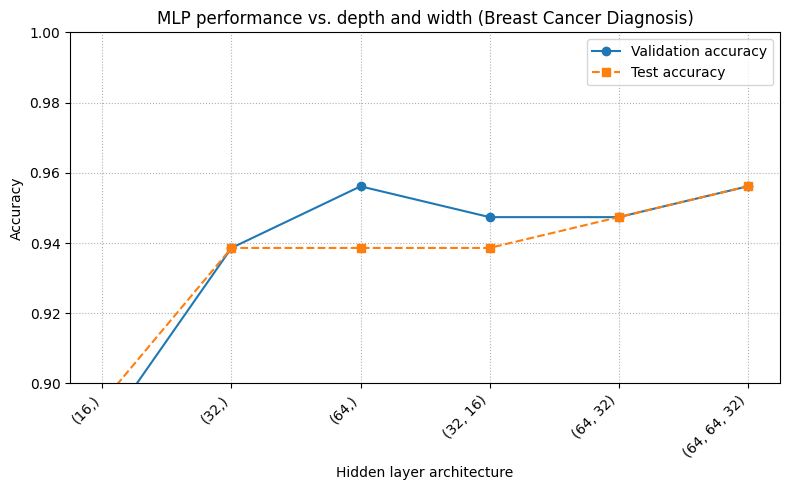

In [16]:
# Create a directory for figures (if it does not exist yet)
import os

os.makedirs("figures", exist_ok=True)

# Prepare data for plotting
labels = [str(a) for a in results_df["architecture"]]
x = np.arange(len(labels))

plt.figure(figsize=(8, 5))

# Plot validation and test accuracy with different markers/line styles
plt.plot(x, results_df["val_acc"], marker="o", linestyle="-", label="Validation accuracy")
plt.plot(x, results_df["test_acc"], marker="s", linestyle="--", label="Test accuracy")

plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.xlabel("Hidden layer architecture")
plt.title("MLP performance vs. depth and width (Breast Cancer Diagnosis)")
plt.ylim(0.9, 1.0)
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.savefig("figures/mlp_accuracy_vs_architecture.png", dpi=300, bbox_inches="tight")
plt.show()

## 10. Selecting the Best Architecture and Analysing Errors

We select the architecture with the **highest validation accuracy** as our best model. We then:

- Retrain (or reuse) this best model.
- Evaluate it on the held-out test set.
- Display a **confusion matrix** and **classification report** (precision, recall, F1-score).

Best architecture (by validation accuracy): (64,)
Train accuracy: 0.965
Validation accuracy: 0.956
Test accuracy: 0.939


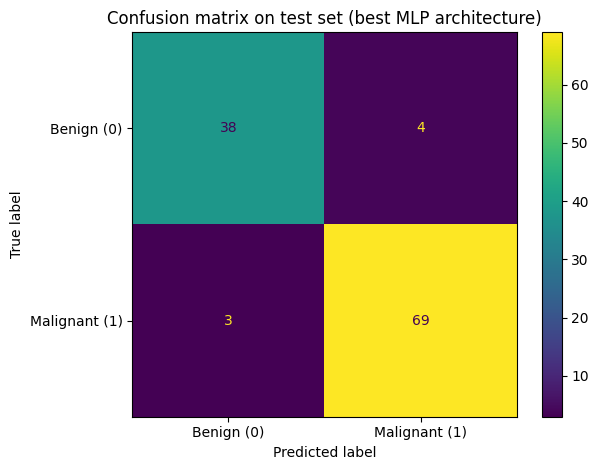

Classification report (test set):

              precision    recall  f1-score   support

      Benign       0.93      0.90      0.92        42
   Malignant       0.95      0.96      0.95        72

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



In [17]:
# Find the index of the best validation accuracy
best_idx = results_df["val_acc"].idxmax()
best_arch = results_df.loc[best_idx, "architecture"]
print("Best architecture (by validation accuracy):", best_arch)

# Retrain (or reuse) the best model for clarity in the notebook
best_model, train_acc, val_acc, test_acc = train_evaluate_mlp(best_arch)

print(f"Train accuracy: {train_acc:.3f}")
print(f"Validation accuracy: {val_acc:.3f}")
print(f"Test accuracy: {test_acc:.3f}")

# Predictions on the test set
y_test_pred = best_model.predict(X_test_scaled)

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign (0)", "Malignant (1)"])
disp.plot()
plt.title("Confusion matrix on test set (best MLP architecture)")
plt.tight_layout()
plt.show()

# Classification report
print("Classification report (test set):\n")
print(classification_report(y_test, y_test_pred, target_names=["Benign", "Malignant"]))

## 11. Discussion and Conclusions

From these experiments, we can draw several conclusions about the effect of depth and width on MLP performance
for this medical diagnosis task:

- Even relatively shallow networks (a single hidden layer) can achieve high accuracy on this dataset.
- Increasing the width (number of neurons) often provides small improvements, but with diminishing returns.
- Adding more hidden layers (increasing depth) can improve performance slightly, but beyond a certain point
  it may lead to overfitting, where training accuracy is high but validation/test accuracy does not improve.
- Proper feature scaling, stratified splits, and early stopping are crucial for stable training and
  fair evaluation.

You can now use the results, figures, and explanations from this notebook as the basis for your written tutorial
(web page, PDF) or as a script for a short video tutorial explaining the impact of MLP architecture choices on
a real medical dataset.